<a href="https://colab.research.google.com/github/RiemanBall/Machine-Learning/blob/master/LogisticRegression/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with Logistic Regression
This notebook build a Logistic Regression from scratch to predict whether the income of an indivisual exceeds 50,000.

In [1]:
import numpy as np
np.random.seed(0)

from math import ceil

from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
%matplotlib inline

## Dataset
The dataset used here is from https://www.kaggle.com/c/ml2020spring-hw2/data, which is modified from [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)) and can be found in [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php).

In [2]:
!gdown --id '1KSFIRh0-_Vr7SdiSCZP1ItV7bXPxMD92' --output data.tar.gz
!tar -zxvf data.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1KSFIRh0-_Vr7SdiSCZP1ItV7bXPxMD92
To: /content/data.tar.gz
6.11MB [00:00, 16.8MB/s]
data/
data/sample_submission.csv
data/test_no_label.csv
data/train.csv
data/X_test
data/X_train
data/Y_train


### Preprocessing
- Read data:

    > Note that `X_train` and `X_test` is already preprocessed with one-hot encoding.

- Normalize data
- Split to training set and validation set

In [3]:
# Read data from csv files
X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

In [4]:
def normalize(X, train=True, columns=None, X_mean=None, X_std=None):
    '''
    This function serves for normalizing both training set and testing set.
    Inputs:
        X: Nxm ndarray. N data, m features
        train: Boolean. True when X is training data. False when X is testing data
        columns: ndarray. Specify the indices of columns to be normalized
        X_mean: Nx1 ndarray. N Mean values for each data point, used to normalize testing data
        X_std: Nx1 ndarray. N standard deviation for each data point, used to normalize testing data
    Outputs:
        X: normalized data
        X_mean: mean of X if X is training data
        X_std: standard deviation of X if X is training data
    '''
    if columns is None:
        columns = np.arange(X.shape[1])

    if train:
        X_mean = np.mean(X[:, columns], 0).reshape(1, -1)
        X_std = np.std(X[:, columns], 0).reshape(1, -1)

    X[:, columns] = (X[:, columns] - X_mean) / (X_std + 1e-8)   # In case X_std is zero

    return X, X_mean, X_std


# Normalize dataset
X_train, X_mean, X_std = normalize(X_train, train = True)
X_test, _, _= normalize(X_test, train = False, columns = None, X_mean = X_mean, X_std = X_std)

### Some helping functions

In [5]:
# Helping function
def sigmoid(z):
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1.0 / (1.0 + np.exp(-z)), 1e-8, 1 - 1e-8)

def adam(grads, vs, ms, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-6
    
    for grad, v, m in zip(grads, vs, ms):
        m[:] = beta1 * m + (1 - beta1) * grad
        v[:] = beta2 * v + (1 - beta2) * np.square(grad)

        m_bias_corr = m / (1 - beta1 ** t)
        v_bias_corr = v / (1 - beta2 ** t)

        grad[:] = m_bias_corr / (np.sqrt(v_bias_corr) + eps_stable)

    return grads, vs, ms


def shuffle(X, Y):
    '''
    Shuffle dataset. X and Y should have same length at 0-dimension.
    Inputs:
        X: Nxm ndarray. N data, m features
        Y: Nx1 ndarray. N data, 1 label
    Outputs:
        X: Nxm ndarray. Shuffled X. N data, m features
        Y: Nx1 ndarray. Shuffled Y. N data, 1 label
    '''
    if X.shape[0] != Y.shape[0]:
        print("Shape of X doesn't match with shape of Y")
        return None

    if len(Y.shape) < 2:
        Y = Y.reshape(-1, 1)

    rand_indices = np.arange(X.shape[0])
    np.random.shuffle(rand_indices)
    return X[rand_indices, :], Y[rand_indices, :]

def accuracy(Y_pred_class, Y_truth):
    acc = 1 - np.mean(np.abs(Y_pred_class - Y_truth))
    return acc

### Split the data
Before splitting the data, we shuffle it to have random sequence. Then we split to training set and validation set.

In [6]:
def split_train_val(X, Y, train_ratio=0.8):
    '''
    Split dataset (X, Y) to training set and validation set with training ratio = train_ratio
    '''
    num_data = X.shape[0]
    train_sz = ceil(num_data * train_ratio)
    return X[:train_sz], Y[:train_sz], X[train_sz:], Y[train_sz:]

# Shuffle the data
X_train, Y_train = shuffle(X_train, Y_train)
# Split to training set and validation set
X_train_set, Y_train_set, X_val_set, Y_val_set = split_train_val(X_train, Y_train)

train_size = X_train_set.shape[0]
val_size = X_val_set.shape[0]
test_size = X_test.shape[0]
data_dim = X_train_set.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of validation set: {}'.format(val_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 43405
Size of validation set: 10851
Size of testing set: 27622
Dimension of data: 510


## Logistic Regression Model
The LR model contains:
- Cost function: Regularized cross-entropy

    For a binary classification, the cost function is:
    
>> L = cross entropy loss + regularization

>> cross entropy loss = $-\{y^T\log(h_w(X)) + (1-y)^T\log(1-h_w(X))\}$

>> regularization = 
\begin{cases}
    \lambda ||W||_1  & \text{Lasso}\\
    \frac{\lambda}{2}\sum^m_i{w_i^2} & \text{L2-norm}\\
\end{cases} 

>> where

\begin{equation}
X \in R^{n\times m}\\
h_w(X) = \sigma(XW + b)\\
\end{equation}

>> with $n$ = batch size, $m$ = number of features

- Gradient of cost function w.r.t. weight and bias
\
\
\begin{equation}
\frac{\partial{L}}{\partial{W}} = X^T (h_w(X) - y) + 
    \begin{cases}
        \lambda sign(W)  & \text{Lasso}\\
        \lambda \cdot W & \text{L2-norm}\\
    \end{cases}\\
\frac{\partial{L}}{\partial{b}} = (h_w(X) - y)
\end{equation}

- Training function
- Prediction function




In [7]:
from enum import Enum
class Regularization(Enum):
    L1 = 1
    L2 = 2


class LogisticRegression (object):
    def __init__(self, lr = 1e-1, max_epoch = 10, reg_rate = 1e-2):
        self.W = None
        self.b = None
        self.regularization = None
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        self.loss_converge = 1e-4
        self.acc_converge = 1e-4
        self.patience = 3

        self.learning_rate = lr
        self.max_epoch = max_epoch
        self.reg_rate = reg_rate
    
    # Cost function
    def cross_entropy_loss(self, Y_pred, Y_truth):
        cross_entropy = -Y_truth.T @ np.log(Y_pred) - (1 - Y_truth.T) @ np.log(1 - Y_pred)
        return cross_entropy.item() + self.regularization_loss()
        
    def regularization_loss(self):
        if self.regularization == Regularization.L1:
            return self.reg_rate * np.linalg.norm(self.W, ord = 1)
        elif self.regularization == Regularization.L2:
            return self.reg_rate / 2.0 * np.sum(np.square(self.W))
        else:
            return 0

    def gradient(self, X, Y_truth):
        # Compute the gradient dLdW and dLdb
        Y_pred = self.predict(X)
        error = Y_pred - Y_truth
        dLdW = X.T @ error + self.regularization_gradient()
        dLdb = np.sum(error).reshape(1,)

        return [dLdW, dLdb]

    def regularization_gradient(self):
        if self.regularization == Regularization.L1:
            return self.reg_rate * np.sign(self.W)
        elif self.regularization == Regularization.L2:
            return self.reg_rate * self.W
        else:
            return 0

    def train(self, X_train, Y_train, X_val = None, Y_val = None, batch_size = 10, regularization = None, verbose = False):
        self.regularization = regularization
        num_train, num_features = X_train.shape
        
        if len(Y_train.shape) < 2:
            Y_train = Y_train.reshape(-1, 1)

        if X_val is not None:
            num_val = X_val.shape[0]
            if len(Y_val.shape) < 2:
                Y_val = Y_val.reshape(-1, 1)

        # Xavier Initialization
        bound = 1.0 / np.sqrt(num_train)
        self.W = np.random.uniform(low = -bound, high = bound, size = num_features).reshape(-1, 1)
        self.b = np.zeros((1,))
        vs = [np.zeros_like(self.W), np.zeros_like(self.b)]
        ms = [np.zeros_like(self.W), np.zeros_like(self.b)]
        step = 0

        best_loss = np.Inf
        best_acc  = 0
        loss_violate = 0
        acc_violate  = 0

        for epoch in range(self.max_epoch):
            # Shuffle the training data
            X_train, Y_train = shuffle(X_train, Y_train)

            # Mini-batch gradient descent
            num_batches = num_train // batch_size
            for i_batch in range(num_batches):
                start = i_batch * batch_size
                end = (i_batch + 1) * batch_size if i_batch != num_batches - 1 else num_train   # Use all the rest if this is the last batch
                X = X_train[start : end]
                Y = Y_train[start : end]

                step += 1

                # dLdW, dLdb = self.gradient(X, Y)
                grads = self.gradient(X, Y)
                [dLdW, dLdb], vs, ms = adam(grads, vs, ms, step)

                self.W -= self.learning_rate * dLdW
                self.b -= self.learning_rate * dLdb

            # Compute and record loss and accuracy
            Y_train_pred_prob  = self.predict(X_train)
            Y_train_pred_class = np.around(Y_train_pred_prob).astype(np.int)
            self.train_loss.append(self.cross_entropy_loss(Y_train_pred_prob, Y_train) / num_train)
            self.train_acc.append(accuracy(Y_train_pred_class, Y_train))
            
            if np.isnan(self.train_loss[-1]):
                print("Training loss is NAN")
                return

            if X_val is not None:
                Y_val_pred_prob  = self.predict(X_val)
                Y_val_pred_class = np.around(Y_val_pred_prob).astype(np.int)
                self.val_loss.append(self.cross_entropy_loss(Y_val_pred_prob, Y_val) / num_val)
                self.val_acc.append(accuracy(Y_val_pred_class, Y_val))
            
                if np.isnan(self.val_loss[-1]):
                    print("Validation loss is NAN")
                    return

            if verbose and (epoch % 10 == 0 or epoch == self.max_epoch - 1):
                print(f"Epoch: {epoch}")
                print(f'Training loss: {self.train_loss[-1]}')
                if X_val is not None:
                    print(f'Validation loss: {self.val_loss[-1]}')
                print(f'Training accuracy: {self.train_acc[-1]}')
                if X_val is not None:
                    print(f'Validation accuracy: {self.val_acc[-1]}')
                print('--------------------------------------------------------------')

            # Early exit for loss convergence
            if len(self.train_loss) > 1 and best_loss > self.train_loss[-1]:
                best_loss = self.train_loss[-1]
                loss_violate = 0
            elif self.train_loss[-1] - best_loss < self.loss_converge:
                loss_violate += 1
                if loss_violate > self.patience:
                    print("Early exit -- Loss converges!")
                    return

            # Early exit for accuracy convergence
            if len(self.train_acc) > 1 and best_acc < self.train_acc[-1]:
                best_acc = self.train_acc[-1]
                acc_violate = 0
            elif best_acc - self.train_acc[-1] < self.acc_converge:
                acc_violate += 1
                if acc_violate > self.patience:
                    print("Early exit -- Accuracy converges!")
                    return

    def predict(self, X):
        '''
        Output of logistic regression function.
        Inputs:
            X: Nxm ndarray. N data, m features
        Outputs:
            Probabilities: Nx1 ndarray. Predicted probability of each row of X being positively labeled
        '''
        return sigmoid(X @ self.W + self.b)

    def classify(self, X):
        '''
        Classify the class by rounding the predicted probability computed from each row of features in X
        Inputs:
            X: Nxm ndarray. N data, m features
        Outputs:
            classes: Nx1 ndarray. 
        '''
        return np.around(self.predict(X)).astype(np.int)

## Train LR model
- Use K-fold cross validation
- We will implement grid search to find the best hyperparameters

### K-fold cross validation

#### L1 regularization

In [ ]:
kfold = KFold(10, True, 1)
lrs = [1e-3, 5e-4, 1e-4]
reg_rates = [1e-3, 5e-4, 1e-4, 0]

accs_l1 = [[] for _ in range(len(lrs))]

for i, lr in enumerate(lrs):
    for j, reg_r in enumerate(reg_rates):
        print(f"Learning rate: {lr}, regularization rate: {reg_r}")

        LR = LogisticRegression(lr = lr, max_epoch = 20, reg_rate = reg_r)
        
        # enumerate splits
        for k, (train_ind, test_ind) in enumerate(kfold.split(X_train)):
            print(f"No.{k}-fold")
            X_train_set, Y_train_set = X_train[train_ind], Y_train[train_ind]
            X_val_set, Y_val_set = X_train[test_ind], Y_train[test_ind]
            LR.train(X_train_set, Y_train_set, X_val_set, Y_val_set, batch_size = 20, regularization = Regularization.L1, verbose = True)

        accs_l1[i].append((LR.train_acc[-1], LR.val_acc[-1]))


In [ ]:
# Based on the result of using L1 regularization, we choose lr = 5e-4 and no regularization
for row in accs_l1:
    for train, val in row:
        print(f"({train:.6f},{val:.6f})", end=', ')
    print("")


(0.884049,0.884424), (0.881940,0.882028), (0.883373,0.882028), (0.884745,0.880369), 
(0.884786,0.883134), (0.884807,0.882949), (0.884889,0.884608), (0.885012,0.885346), 
(0.883967,0.883502), (0.884233,0.882949), (0.883762,0.884793), (0.883762,0.882949), 


#### L2 regularization

In [ ]:
kfold = KFold(10, True, 1)
lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
reg_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 0]

accs_l2 = [[] for _ in range(len(lrs))]

for i, lr in enumerate(lrs):
    for j, reg_r in enumerate(reg_rates):
        print(f"Learning rate: {lr}, regularization rate: {reg_r}")

        LR = LogisticRegression(lr = lr, max_epoch = 20, reg_rate = reg_r)
        
        # enumerate splits
        for k, (train_ind, test_ind) in enumerate(kfold.split(X_train)):
            print(f"No.{k}-fold")
            X_train_set, Y_train_set = X_train[train_ind], Y_train[train_ind]
            X_val_set, Y_val_set = X_train[test_ind], Y_train[test_ind]
            LR.train(X_train_set, Y_train_set, X_val_set, Y_val_set, batch_size = 20, regularization = Regularization.L2, verbose = True)

        accs_l2[i].append((LR.train_acc[-1], LR.val_acc[-1]))


In [ ]:
# Based on the result of using L2 regularization, we choose lr = 5e-4 and regularization rate = 1e-3
for row in accs_l2:
    for train, val in row:
        print(f"({train:.6f},{val:.6f})", end=', ')
    print("")


(0.863734,0.860461), (0.863796,0.857696), (0.861830,0.858802), (0.864471,0.861198), (0.864942,0.861751), (0.865372,0.857696), 
(0.873523,0.867097), (0.874424,0.873364), (0.868035,0.867281), (0.871086,0.869309), (0.873298,0.871336), (0.871946,0.864885), 
(0.883865,0.883687), (0.883230,0.884608), (0.883271,0.880369), (0.882820,0.880184), (0.883947,0.877972), (0.883435,0.880922), 
(0.885360,0.884055), (0.885749,0.882949), (0.885360,0.884055), (0.884479,0.883871), (0.883455,0.882396), (0.884418,0.882765), 
(0.883639,0.883871), (0.883701,0.882028), (0.884172,0.883318), (0.884049,0.882949), (0.884151,0.883502), (0.883906,0.884793), 


### Train the model
Based on the grid search result, we pick the hyperparameters as shown in the code cell below:

In [8]:
X_train_set, Y_train_set, X_val_set, Y_val_set = split_train_val(X_train, Y_train)

LR = LogisticRegression(lr = 5e-4, max_epoch = 50, reg_rate = 1e-3)
LR.train(X_train_set, Y_train_set, X_val_set, Y_val_set, batch_size = 20, regularization = Regularization.L2, verbose = True)

Epoch: 0
Training loss: 0.3555621849024444
Validation loss: 0.35663918718366305
Training accuracy: 0.8665821909918212
Validation accuracy: 0.8631462538014929
--------------------------------------------------------------
Epoch: 10
Training loss: 0.26849849048457314
Validation loss: 0.2768384982783344
Training accuracy: 0.8852897131666859
Validation accuracy: 0.8811169477467514
--------------------------------------------------------------
Epoch: 20
Training loss: 0.26776829863042895
Validation loss: 0.27771883141864934
Training accuracy: 0.8847598202972008
Validation accuracy: 0.8803796885079717
--------------------------------------------------------------
Epoch: 30
Training loss: 0.2670395643824336
Validation loss: 0.2786133313503773
Training accuracy: 0.8851284414237991
Validation accuracy: 0.8797345866740393
--------------------------------------------------------------
Epoch: 40
Training loss: 0.2661082000289903
Validation loss: 0.27824493859460975
Training accuracy: 0.88531275198

### Plot the training result

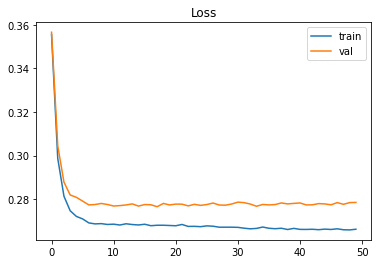

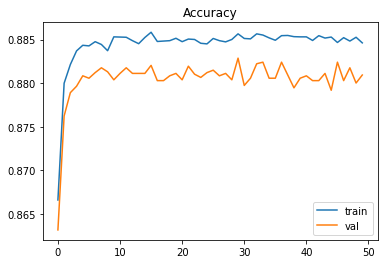

In [9]:
# Loss curve
plt.plot(LR.train_loss)
plt.plot(LR.val_loss)
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

# Accuracy curve
plt.plot(LR.train_acc)
plt.plot(LR.val_acc)
plt.title('Accuracy')
plt.legend(['train', 'val'])
plt.show()

#### Train the model with whole training set


In [10]:
LR.train(X_train_set, Y_train_set, batch_size = 20, regularization = Regularization.L2, verbose = True)

Epoch: 0
Training loss: 0.36078748584618625
Training accuracy: 0.8666513074530584
--------------------------------------------------------------
Epoch: 10
Training loss: 0.2691723438305561
Training accuracy: 0.8850362861421495
--------------------------------------------------------------
Epoch: 20
Training loss: 0.26816673657524226
Training accuracy: 0.8849671696809124
--------------------------------------------------------------
Epoch: 30
Training loss: 0.26669481541489864
Training accuracy: 0.8847367814767884
--------------------------------------------------------------
Epoch: 40
Training loss: 0.26627135701099547
Training accuracy: 0.8851975578850363
--------------------------------------------------------------
Epoch: 49
Training loss: 0.26535623874254477
Training accuracy: 0.8852666743462735
--------------------------------------------------------------


### Look at the most significant 10 features

In [11]:
# Print out the most significant weights
ind = np.argsort(np.abs(LR.W), axis=0)[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10,0]:
    print(f"{features[i+1].strip():>45} --> {LR.W[i, 0]}")

                                capital gains --> 1.092774252463708
                         weeks worked in year --> 0.7745030573413763
                        dividends from stocks --> 0.6813480045725747
                                          age --> 0.5828953173016217
                                     Nonfiler --> -0.4633655391923445
              num persons worked for employer --> 0.3501750904712272
       Masters degree(MA MS MEng MEd MSW MBA) --> 0.283113743567795
                Other relative of householder --> -0.2822649772019038
                                    Nicaragua --> -0.26363891833390335
                                         Male --> 0.26354160472501503


### Compare with sklearn

In [ ]:
LR_skl = linear_model.LogisticRegression(max_iter=1000, penalty='l2', C = 1e3, n_jobs=-1)
LR_skl.fit(X_train, Y_train.reshape(Y_train.shape[0], ))

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Avoid large data copy
k = 10
subsize = ceil(Y_train.shape[0] / k)
Y_train_pred_class = np.zeros_like(Y_train)
for i in range(k):
    Y_train_pred_class[i*subsize : (i+1)*subsize, 0] = LR_skl.predict(X_train[i*subsize : (i+1)*subsize, :])
print(f"Accuracy of sklearn Logistic Regression: {accuracy(Y_train_pred_class, Y_train)}")

Accuracy of sklearn Logistic Regression: 0.8856531996461221


In [ ]:
r = permutation_importance(LR_skl, X_train, Y_train,
                           n_repeats=30,
                           n_jobs=-1,
                           random_state=0)

In [ ]:
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)[1:]

ind = r.importances_mean.argsort()[::-1]

for i in ind[0:10]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features[i]:<50}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

 Spouse of householder                            0.028 +/- 0.001
 Householder                                      0.024 +/- 0.001
weeks worked in year                              0.019 +/- 0.001
 Spouse of householder                            0.015 +/- 0.001
capital gains                                     0.013 +/- 0.000
 United-States                                    0.011 +/- 0.000
 Native- Born in the United States                0.010 +/- 0.001
age                                               0.010 +/- 0.001
 Masters degree(MA MS MEng MEd MSW MBA)           0.009 +/- 0.000
 Both parents present                             0.009 +/- 0.000


## Predict testing data
Now we predict the labels for the testing data and write it to output_logistic.csv.

In [ ]:
# Predict testing labels
predictions = LR.classify(X_test)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label[0]))

The testing result in https://www.kaggle.com/c/ml2020spring-hw2/data shows the accuracy = 0.88929